<!--BOOK_INFORMATION-->
<img align="left" style="padding-right:10px;" src="https://github.com/jakevdp/PythonDataScienceHandbook/blob/master/notebooks/figures/PDSH-cover-small.png?raw=1">

*This notebook contains an excerpt from the [Python Data Science Handbook](http://shop.oreilly.com/product/0636920034919.do) by Jake VanderPlas; the content is available [on GitHub](https://github.com/jakevdp/PythonDataScienceHandbook).*

*The text is released under the [CC-BY-NC-ND license](https://creativecommons.org/licenses/by-nc-nd/3.0/us/legalcode), and code is released under the [MIT license](https://opensource.org/licenses/MIT). If you find this content useful, please consider supporting the work by [buying the book](http://shop.oreilly.com/product/0636920034919.do)!*

In [34]:
# 2d scatter plot 
def plot_2dscatter(x,y,label):
    plt.figure(figsize=(20,10))
    cmap=plt.cm.get_cmap('jet', 10)
    plt.scatter(x, y, c=label, cmap=cmap, s=1)

    for i in range(len(proj)):
        plt.text(x[i],y[i], label[i],
              color=cmap(label[i]),fontdict={'weight': 'bold', 'size': 11})
    plt.colorbar(ticks=range(10))
    plt.clim(-0.5, 9.5)

# images viewer
def show_images(data):
    fig, ax = plt.subplots(2, 5, figsize=(8, 3))

    for axi, center in zip(ax.flat, data):
        axi.set(xticks=[], yticks=[])
        axi.imshow(center, interpolation='nearest', cmap=plt.cm.binary)

# Example 1: k-means on digits

To start, let's take a look at applying *k*-means on the same simple digits data that we saw inIn-Depth: Decision Trees and Random Forest sand In Depth: Principal Component Analysis.
Here we will attempt to use *k*-means to try to identify similar digits *without using the original label information*; this might be similar to a first step in extracting meaning from a new dataset about which you don't have any *a priori* label information.

We will start by loading the digits and then finding the ``KMeans`` clusters.
Recall that the digits consist of 1,797 samples with 64 features, where each of the 64 features is the brightness of one pixel in an 8×8 image:

In [21]:
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns; sns.set()  # for plot styling
import numpy as np
from sklearn.datasets import load_digits
import warnings
warnings.filterwarnings("ignore")

# load data
digits = load_digits()
digits.data.shape

(1797, 64)

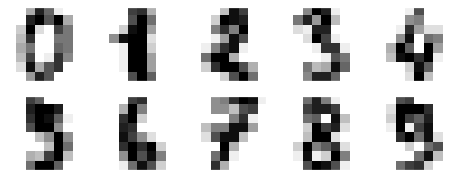

In [29]:
# show sample
show_images( digits.images[0:10])

In [ ]:
# 64 features is the brightness of one pixel in an 8×8 image:
digits.data[5].reshape(8,8)

array([[ 0.,  0., 12., 10.,  0.,  0.,  0.,  0.],
       [ 0.,  0., 14., 16., 16., 14.,  0.,  0.],
       [ 0.,  0., 13., 16., 15., 10.,  1.,  0.],
       [ 0.,  0., 11., 16., 16.,  7.,  0.,  0.],
       [ 0.,  0.,  0.,  4.,  7., 16.,  7.,  0.],
       [ 0.,  0.,  0.,  0.,  4., 16.,  9.,  0.],
       [ 0.,  0.,  5.,  4., 12., 16.,  4.,  0.],
       [ 0.,  0.,  9., 16., 16., 10.,  0.,  0.]])

## PCA

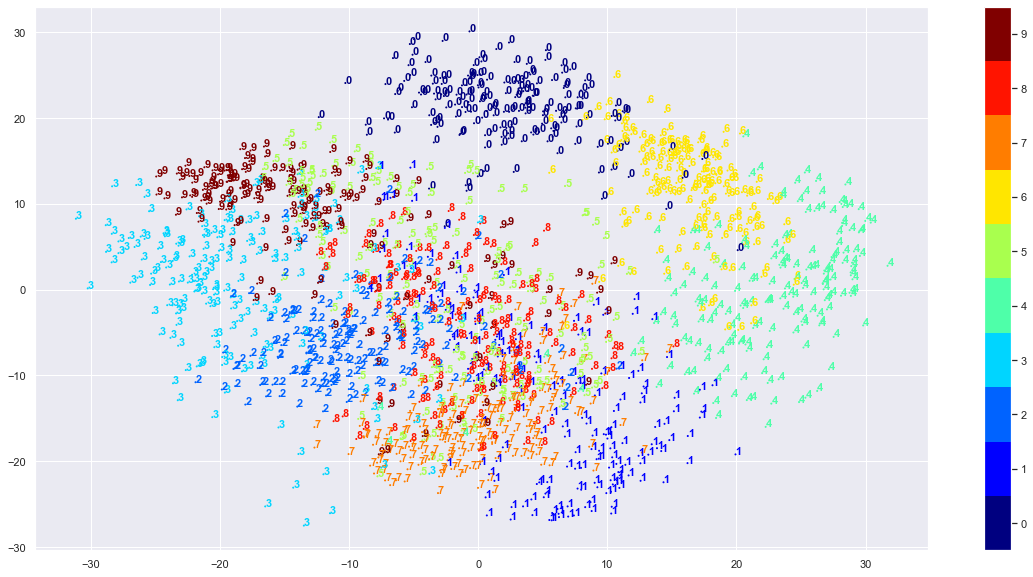

In [61]:
data = digits.data
target = digits.target

from sklearn.decomposition import PCA # Principal Component Analysis module

pca2d = PCA(n_components=2)  
proj = pca2d.fit_transform(data) 

plot_2dscatter(proj[:,0],proj[:,1],target)

##  TSNE

We have seen how principal component analysis (PCA) can be used in the dimensionality reduction task—reducing the number of features of a dataset while maintaining the essential relationships between the points. While PCA is flexible, fast, and easily interpretable, it does not perform so well when there are nonlinear relationships within the data;



Other well-understood methods, such as Principal Component Analysis are great at retaining global structure, because it looks at ways in which a dataset's variance is retained, globally, across the entire dataset.

t-SNE works differently, by looking at locally appearing datapoints. It does this by computing a metric between each datapoint and a given number of neighbours - modelling them as being within a t-distributed distribution (hence the name: t-distributed Stochastic Neighbourhood Embedding). It then tries to find an embedding, such that neighbours in the original n-dimensional space, are also found close together in the reduced (embedded) dimensional space. It does this by minimising the KL-divergence between the before and after datapoint distributions, P and Q respectively. 

[more details](https://datascience.stackexchange.com/questions/36889/what-does-it-mean-by-t-sne-retains-the-structure-of-the-data)

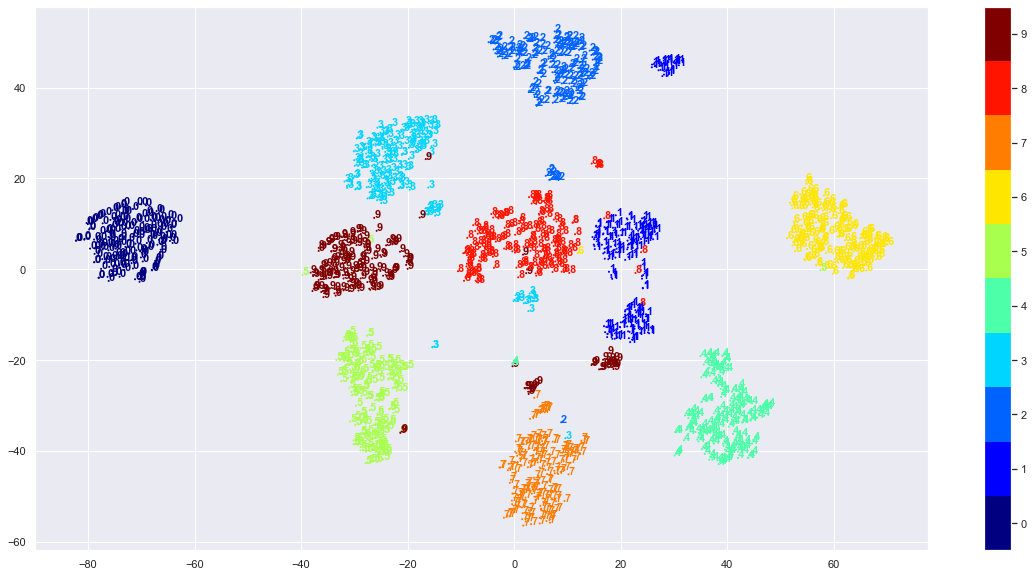

In [62]:
data = digits.data
target = digits.target

from sklearn.manifold import TSNE

# Project the data: this step will take several seconds
tsne = TSNE(n_components=2, init='random', random_state=0)
proj = tsne.fit_transform(data)

plot_2dscatter(proj[:,0],proj[:,1],target)

## KMeans

In [63]:
from sklearn.cluster import KMeans
kmeans = KMeans(n_clusters=10, random_state=0)
clusters = kmeans.fit_predict(data)
kmeans.cluster_centers_.shape

(10, 64)

The result is 10 clusters in 64 dimensions.
Notice that the cluster centers themselves are 64-dimensional points, and can themselves be interpreted as the "typical" digit within the cluster.
Let's see what these cluster centers look like:

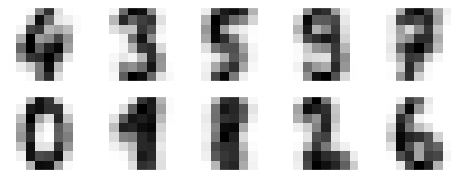

In [32]:
centers = kmeans.cluster_centers_.reshape(10, 8, 8)
show_images(centers)

We see that *even without the labels*, ``KMeans`` is able to find clusters whose centers are recognizable digits, with perhaps the exception of 1 and 8.



### Kmeans accuracy in finding similar digits
Because *k*-means knows nothing about the identity of the cluster, the 0–9 labels may be permuted.
We can fix this by matching each learned cluster label with the true labels found in them:

In [64]:
from scipy.stats import mode

# reassigns cluster labels with the true labels found in them:
def fix_labels(clusters):
    labels = np.zeros_like(clusters)
    for i in range(10):
        mask = (clusters == i)
        labels[mask] = mode(digits.target[mask])[0] 
    return labels

Now we can check how accurate our unsupervised clustering was in finding similar digits within the data:

In [65]:
from sklearn.metrics import accuracy_score
labels = fix_labels(clusters)
accuracy_score(digits.target, labels)

0.7935447968836951

With just a simple *k*-means algorithm, we discovered the correct grouping for 80% of the input digits!
Let's check the confusion matrix for this:

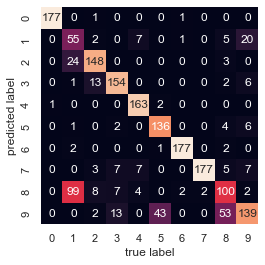

In [66]:
from sklearn.metrics import confusion_matrix
mat = confusion_matrix(digits.target, labels)
sns.heatmap(mat.T, square=True, annot=True, fmt='d', cbar=False,
            xticklabels=digits.target_names,
            yticklabels=digits.target_names)
plt.xlabel('true label')
plt.ylabel('predicted label');

As we might expect from the cluster centers we visualized before, the main point of confusion is between the eights and ones.
But this still shows that using *k*-means, we can essentially build a digit classifier *without reference to any known labels*!

## TSNE + KMeans
Just for fun, let's try to push this even farther.
We can use the t-distributed stochastic neighbor embedding (t-SNE) algorithm (mentioned in [In-Depth: Manifold Learning](05.10-Manifold-Learning.ipynb)) to pre-process the data before performing *k*-means.
t-SNE is a nonlinear embedding algorithm that is particularly adept at preserving points within clusters.
Let's see how it does:

In [67]:
from sklearn.manifold import TSNE

# Project the data: this step will take several seconds
tsne = TSNE(n_components=2, init='random', random_state=0)
digits_proj = tsne.fit_transform(digits.data)

# Compute the clusters
kmeans = KMeans(n_clusters=10, random_state=0)
clusters = kmeans.fit_predict(digits_proj)

# Permute the labels
labels = fix_labels(clusters)

# Compute the accuracy
accuracy_score(digits.target, labels)

0.9432387312186978

That's nearly 94% classification accuracy *without using the labels*.
This is the power of unsupervised learning when used carefully: it can extract information from the dataset that it might be difficult to do by hand or by eye.

In [68]:
import sys 
#  umap-learn for umap dimension reduction
!{sys.executable} -m pip install umap-learn

In [70]:
from sklearn.manifold import TSNE

# Project the data: this step will take several seconds
um = UMAP(random_state=0)
digits_proj = um.fit_transform(data)

# Compute the clusters
kmeans = KMeans(n_clusters=10, random_state=0)
clusters = kmeans.fit_predict(digits_proj)

# Permute the labels
labels = fix_labels(clusters)

# Compute the accuracy
accuracy_score(digits.target, labels)

0.8814691151919867

0.8814691151919867

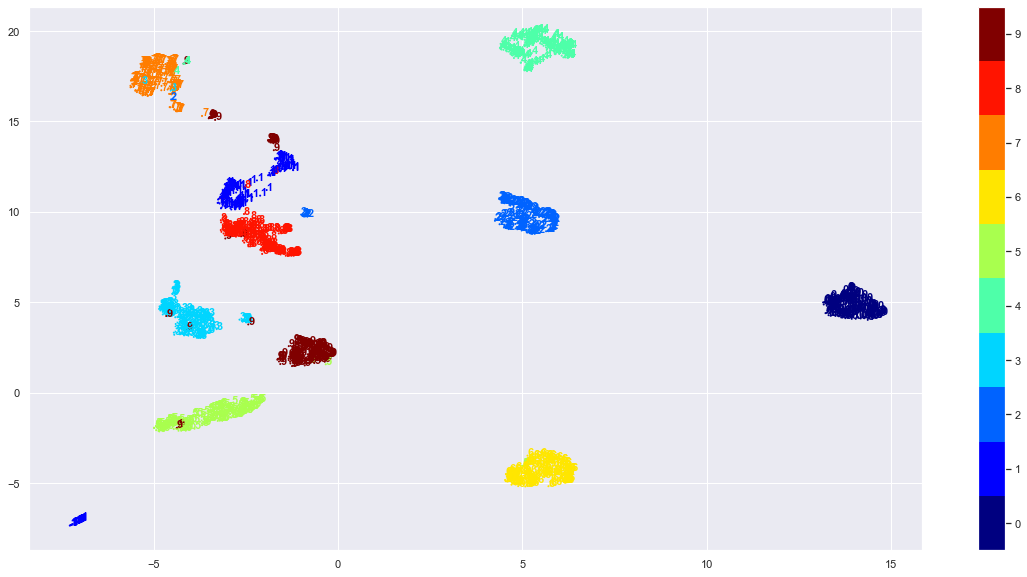

In [58]:
from umap import UMAP

# Project the data: this step will take several seconds
um = UMAP(random_state=0)
digits_proj = um.fit_transform(digits.data)

plot_2dscatter(digits_proj[:,0],digits_proj[:,1],target)

# Compute the clusters
kmeans = KMeans(n_clusters=10, random_state=0)
clusters = kmeans.fit_predict(digits_proj)

# Permute the labels
labels = fix_labels(clusters)

# Compute the accuracy
accuracy_score(digits.target, labels)

That's nearly 95.6% classification accuracy without using the labels. This is the power of unsupervised learning when used carefully: it can extract information from the dataset that it might be difficult to do by hand or by eye.

## PCA + Kmeans

0.5943238731218697

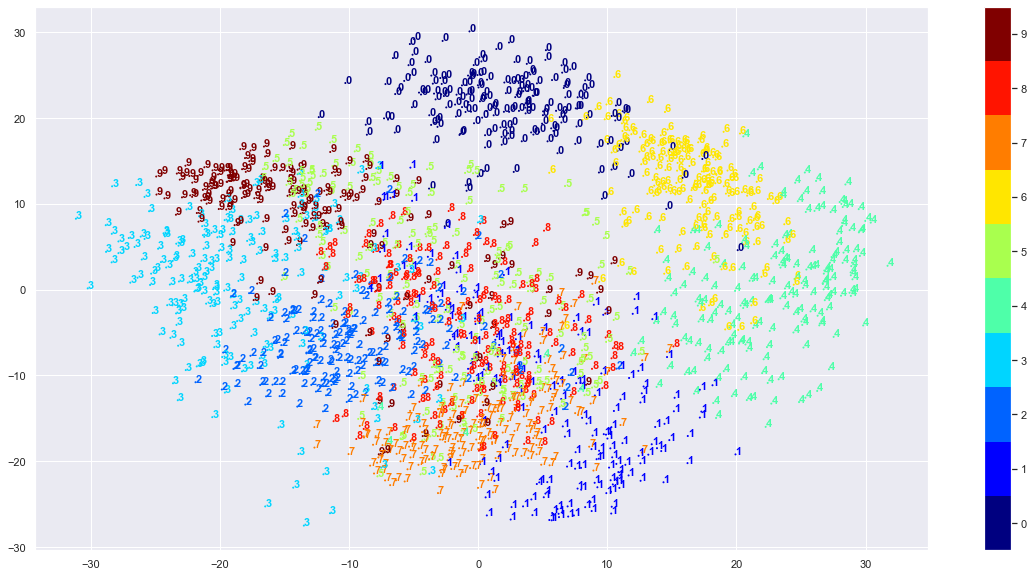

In [71]:
# Project the data: 
pca2d = PCA(n_components=2)  
digits_proj = pca2d.fit_transform(data) 

plot_2dscatter(digits_proj[:,0],digits_proj[:,1],target)

# Compute the clusters
kmeans = KMeans(n_clusters=10, random_state=0)
clusters = kmeans.fit_predict(digits_proj)

# Permute the labels
labels = fix_labels(clusters)

# Compute the accuracy
accuracy_score(digits.target, labels)